<h1><center>Help Your Robot</center></h1>
<center>New York University <br> CS 6133<br> Project1<br>Joh Eun Kang (N11691404)</center>

                                            

![alt text](https://www.sciencenews.org/wp-content/uploads/2019/11/110819_ts_ai_feat-1028x579.jpg)

# 1) Importing Library

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV

# 2) Load the Data sets 

In [0]:
X_train = pd.read_csv("X_train_new.csv")
X_test = pd.read_csv("X_test_new.csv")
y_train = pd.read_csv("y_train_new.csv")
y_test = pd.read_csv("y_test_new.csv")

In [933]:
X_train.columns,X_test.columns,y_train.columns,y_test.columns

(Index(['Unnamed: 0', 'row_id', 'series_id', 'measurement_number',
        'orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
        'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
        'linear_acceleration_X', 'linear_acceleration_Y',
        'linear_acceleration_Z'],
       dtype='object'),
 Index(['Unnamed: 0', 'row_id', 'series_id', 'measurement_number',
        'orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
        'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
        'linear_acceleration_X', 'linear_acceleration_Y',
        'linear_acceleration_Z'],
       dtype='object'),
 Index(['Unnamed: 0', 'series_id', 'group_id', 'surface'], dtype='object'),
 Index(['Unnamed: 0', 'series_id', 'group_id', 'surface'], dtype='object'))

**since there are unnamed columns in the data, remove it!**


In [0]:
# since there are unnamed columns in the data, remove it!
X_train = X_train.drop(['Unnamed: 0'], axis = 1) 
y_train = y_train.drop(['Unnamed: 0'], axis = 1)
X_test = X_test.drop(['Unnamed: 0'], axis = 1)
y_test = y_test.drop(['Unnamed: 0'], axis = 1)

In [935]:
X_train.columns,X_test.columns,y_train.columns,y_test.columns

(Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
        'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
        'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
        'linear_acceleration_Y', 'linear_acceleration_Z'],
       dtype='object'),
 Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
        'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
        'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
        'linear_acceleration_Y', 'linear_acceleration_Z'],
       dtype='object'),
 Index(['series_id', 'group_id', 'surface'], dtype='object'),
 Index(['series_id', 'group_id', 'surface'], dtype='object'))

# 3) Understanding of Data

## Surface Count

Text(0.5, 1.0, 'Count of different surfaces of y_train data')

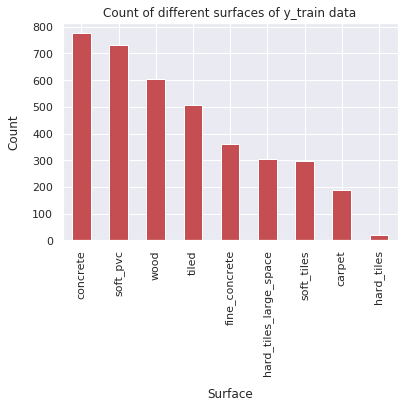

In [936]:
sns.set(font_scale = 1.0)
y_train['surface'].value_counts().plot(kind = "bar",color = 'r');
plt.xlabel("Surface", labelpad = 12)
plt.ylabel("Count", labelpad = 12)
plt.title("Count of different surfaces of y_train data")


**Observation:** <br>
As we can see here, there are large number of data that indicates concrete, soft_pvc, wood,,, etc, but the hard tiles has very small data <br>. So, we need to think about what this graph tells us.<br>

This graph can be interpreted as<br>
1. If hard_tiles do __not have significance__ in its data, the model will be __hard to classify them__.
2. if the hard_tiles __do have significance__ , the small number of data would be __not important__. 


### Found that there are some surfaces that are not in y_test set

In [937]:
y_train_surface = list(y_train['surface'].unique())
y_train_surface

['fine_concrete',
 'concrete',
 'soft_tiles',
 'tiled',
 'soft_pvc',
 'hard_tiles_large_space',
 'carpet',
 'hard_tiles',
 'wood']

In [938]:
y_test_surface = list(y_test['surface'].unique())
y_test_surface

['hard_tiles_large_space',
 'concrete',
 'soft_pvc',
 'tiled',
 'wood',
 'fine_concrete']

In [939]:
set(y_train_surface) - set(y_test_surface)

{'carpet', 'hard_tiles', 'soft_tiles'}

We found that __y_test data does not have the carpet, hard tiles, and soft tiles__. If we assume that we already know the test data set, we can simply remove those three information in data set. However,__in the real world__, the __"y_test data" is usually unknown__. Also, there was no y test in the Kaggle competition as well. Therefore, __we keep these three kinds of surface.__

### Correlations

Let's look at the correlations of the X_train data.

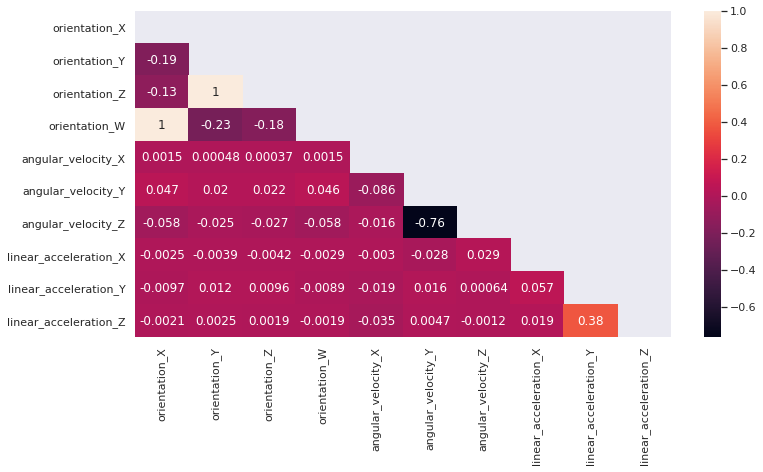

In [940]:
fig, ax = plt.subplots(figsize=(12, 6)) 
mask = np.zeros_like(X_train.iloc[:,3:13].corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(X_train.iloc[:,3:13].corr(), mask= mask, ax= ax, annot= True)

In [941]:
top_corr_X_train= X_train.iloc[:,3::].corr().abs()
sol = (top_corr_X_train.where(np.triu(np.ones(top_corr_X_train.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol[0:15]

orientation_X          orientation_W            0.998373
orientation_Y          orientation_Z            0.997542
angular_velocity_Y     angular_velocity_Z       0.761955
linear_acceleration_Y  linear_acceleration_Z    0.378070
orientation_Y          orientation_W            0.225623
orientation_X          orientation_Y            0.185066
orientation_Z          orientation_W            0.175842
orientation_X          orientation_Z            0.133556
angular_velocity_X     angular_velocity_Y       0.086389
orientation_X          angular_velocity_Z       0.058154
orientation_W          angular_velocity_Z       0.057746
linear_acceleration_X  linear_acceleration_Y    0.057272
orientation_X          angular_velocity_Y       0.046707
orientation_W          angular_velocity_Y       0.046319
angular_velocity_X     linear_acceleration_Z    0.034618
dtype: float64

#### **Observation:**<br>
As we can see from the above,

```python
orientation_X          orientation_W            0.998373
orientation_Y          orientation_Z            0.997542
angular_velocity_Y     angular_velocity_Z       0.761955
``` 
we may think the top three features help the robot for better classification.

# 4) Understanding of X_train, X_test

## Plotting the distributions of features

**Let's look at the distributon of our training and test data set.** 

In [0]:

def feature_distribution(data1, data2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(data1[feature], bw=0.5,label=label1, color = 'r')
        sns.kdeplot(data2[feature], bw=0.5,label=label2, color = 'g')
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

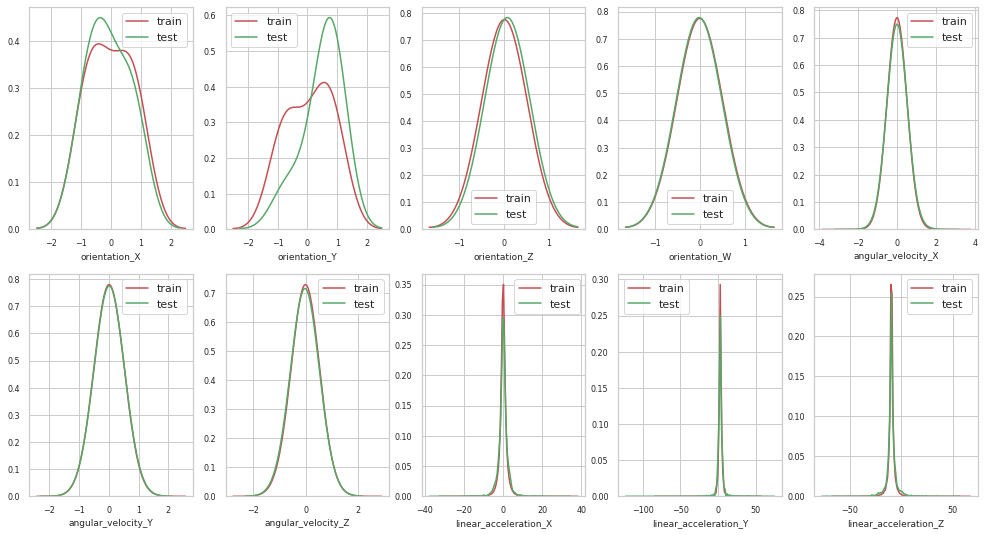

In [943]:
features = X_train.columns.values[3:13]
feature_distribution(X_train, X_test, 'train', 'test', features)

## Statistics of the training set 

In [944]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,485120.00000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000
mean,1894.50000,63.500000,-0.017685,0.072816,0.012113,-0.003729,0.000157,0.008311,-0.019093,0.129337,2.886914,-9.364700
std,1094.07985,36.949328,0.685940,0.708231,0.105991,0.104343,0.117179,0.088570,0.229038,1.863647,2.106743,2.824964
min,0.00000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-31.142000,-82.753000,-65.492000
25%,947.00000,31.750000,-0.705120,-0.690450,-0.090101,-0.106060,-0.040682,-0.033161,-0.090624,-0.530030,1.959400,-10.191000
50%,1894.50000,63.500000,-0.100910,0.235270,0.031747,-0.018173,0.000085,0.005402,-0.005314,0.124870,2.879900,-9.365100
75%,2842.00000,95.250000,0.652380,0.805293,0.122560,0.097421,0.040446,0.047976,0.064601,0.791282,3.798400,-8.524300
max,3789.00000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,55.948000,65.839000


## Class Distribution

**By looking at the class distribution, we know the major diffences of each class**

In [0]:
# modification from the @Nanashi 

def feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(12,20))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=5)
        plt.tick_params(axis='y', which='major', labelsize=5)
    plt.show();

<Figure size 432x288 with 0 Axes>

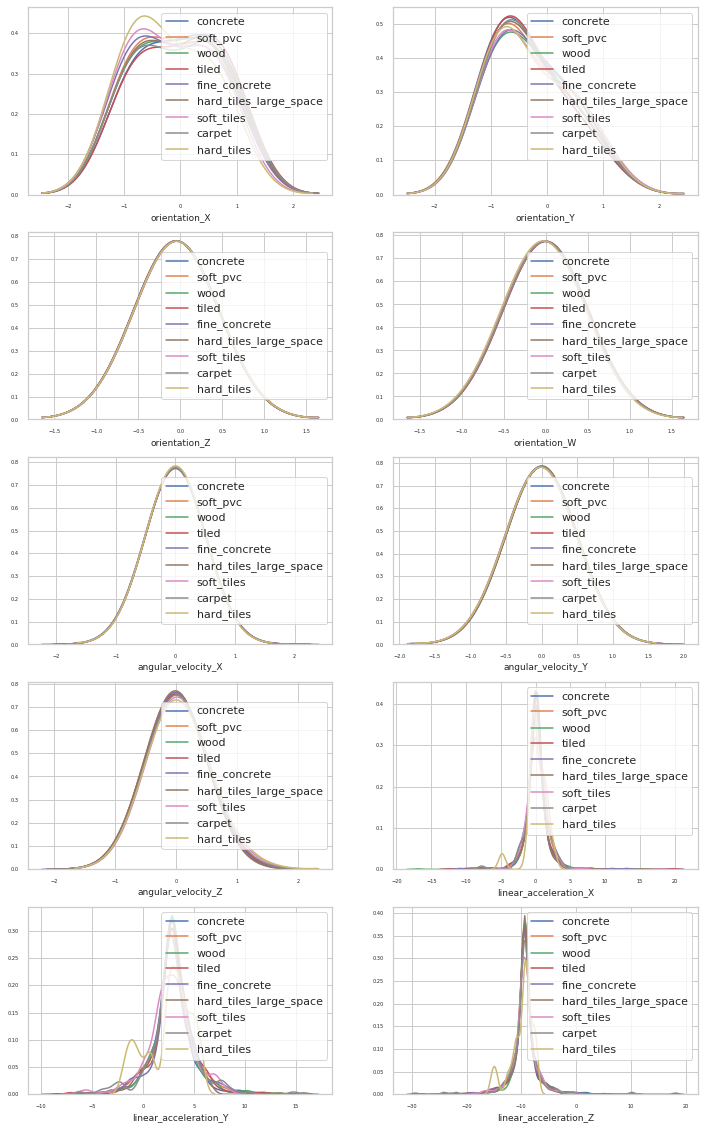

In [946]:
features = X_train.columns.values[3:13]
classes = (y_train['surface'].value_counts()).index
aux = pd.merge(X_train, y_train, left_index=True, right_index=True)
feature_class_distribution(classes, aux, features)

**Observations:**<br>
From the class distribution graph, we have some more information for classifying the trainig data set. 
As we can see from the graphs, there are some class differences in orientation_X, orientation_y, and linear_acceleration_X,Y, and Z. Therefore, __one can think that some statistical anlaysis such as mean, min, max, difference between min and max of each sufacese woud help to classify the data.__ 


Since distribution and class distribution shows that there is relatively high difference in orientation data, we should look closer!.

## Scaling of the Data

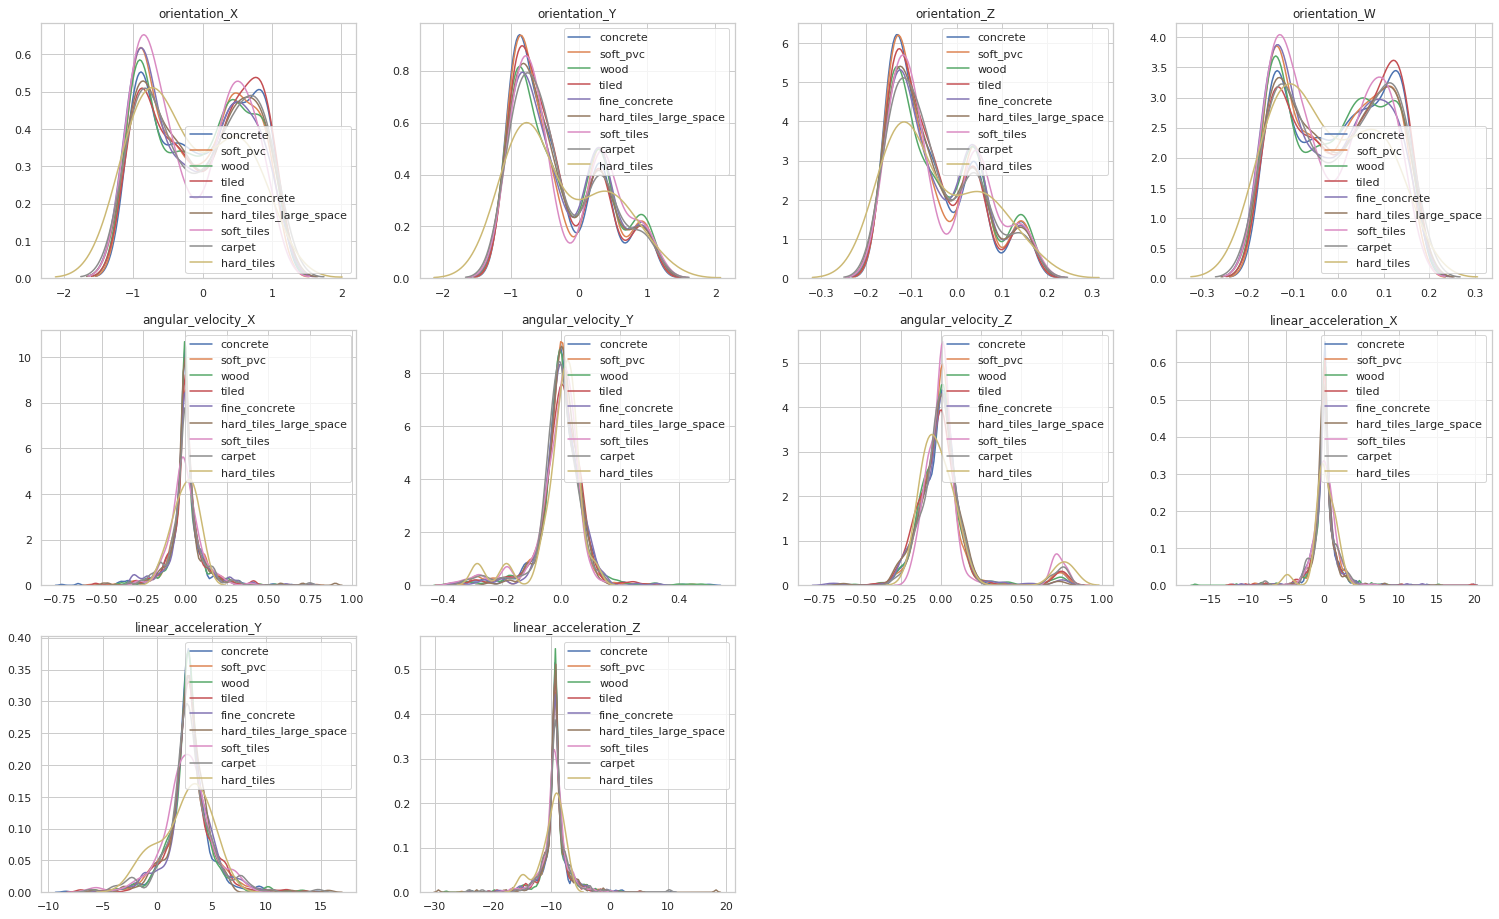

In [947]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

**Observations:**<br>
Since these three kinds of feature have __different unit scale__, we should do the __scaling.__
As we can see from the class distribution with standard scaling, we detected __more differences__ that we couldfrom the non-scaled data. All the graphs show us that there exist some differences between the surfaces. 

Also, from the shape of the graph, we are __more confidence for doing feature engineering__ on the features that we mentioned above. 

### Orientation X,Orientation Y,Orientation Z,Orientation W

Accoding to our data, we can see that orientation data have some siginicances compare to other data. So we need to look closer!.

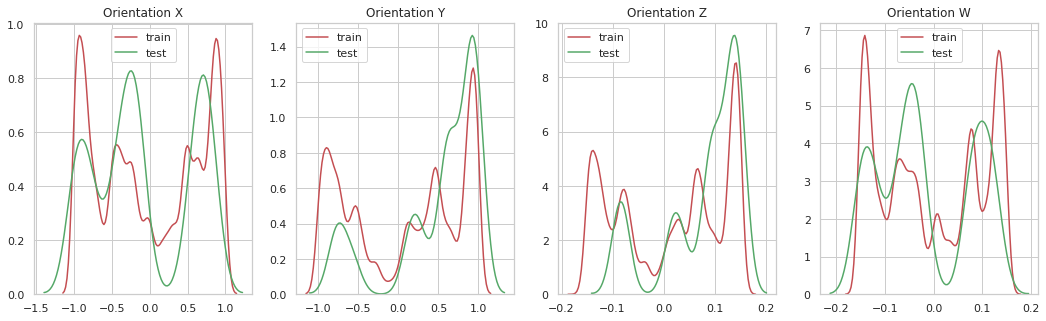

In [948]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('Orientation X')
sns.kdeplot(X_train['orientation_X'], ax=ax1, label="train", color = 'r')
sns.kdeplot(X_test['orientation_X'], ax=ax1, label="test",color = 'g')

ax2.set_title('Orientation Y')
sns.kdeplot(X_train['orientation_Y'], ax=ax2, label="train",color = 'r')
sns.kdeplot(X_test['orientation_Y'], ax=ax2, label="test",color = 'g')

ax3.set_title('Orientation Z')
sns.kdeplot(X_train['orientation_Z'], ax=ax3, label="train",color = 'r')
sns.kdeplot(X_test['orientation_Z'], ax=ax3, label="test",color = 'g')

ax4.set_title('Orientation W')
sns.kdeplot(X_train['orientation_W'], ax=ax4, label="train",color = 'r')
sns.kdeplot(X_test['orientation_W'], ax=ax4, label="test",color = 'g')

plt.show()

**Obsercation:**
There are some significance differences in training and testing of orientation data. Therefore, adding some features  related to the orientations such as standerized range of height,max height, min height, quantiles will help our model.

# 5) Feature Engineering (on X_train and X_test)

### Feature Engineering part 0)

In [0]:
# Feature Enginnering Part 0) 
def normalization(data):
    data['square_sum'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2 + data['orientation_W']**2)
    data['mod_quat'] = (data['square_sum'])**0.5
    data['norm_orientation_X'] = data['orientation_X'] / data['mod_quat']
    data['norm_orientation_Y'] = data['orientation_Y'] / data['mod_quat']
    data['norm_orientation_Z'] = data['orientation_Z'] / data['mod_quat']
    data['norm_orientation_W'] = data['orientation_W'] / data['mod_quat']
    return data

In [0]:
X_train = normalization(X_train)

In [951]:
X_train.head(20)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,square_sum,mod_quat,norm_orientation_X,norm_orientation_Y,norm_orientation_Z,norm_orientation_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.748570,2.103000,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.104880,-0.105970
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.339950,1.506400,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.104900,-0.106000
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.264290,1.592200,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.104920,-0.105970
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.426840,1.099300,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.104950,-0.105970
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.509690,1.468900,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.104950,-0.105960
5,0_5,0,5,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.447450,0.992810,-10.4020,1.000001,1.000001,-0.758529,-0.634390,-0.104830,-0.105800
6,0_6,0,6,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.141630,0.734970,-9.4296,0.999999,1.000000,-0.758530,-0.634410,-0.104810,-0.105690
7,0_7,0,7,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.121600,0.075417,-8.6088,1.000003,1.000002,-0.758519,-0.634439,-0.104800,-0.105610
8,0_8,0,8,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.600000,0.816110,-7.6426,1.000007,1.000003,-0.758507,-0.634448,-0.104850,-0.105590
9,0_9,0,9,-0.75851,-0.63443,-0.10489,-0.10567,-0.090082,0.027299,-0.009970,0.474960,0.909600,-8.8120,1.000007,1.000003,-0.758507,-0.634428,-0.104890,-0.105670


In [0]:
X_test = normalization(X_test)

In [953]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,square_sum,mod_quat,norm_orientation_X,norm_orientation_Y,norm_orientation_Z,norm_orientation_W
0,3790_0,3790,0,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040,0.999999,1.000000,0.709920,0.688010,0.10876,0.10405
1,3790_1,3790,1,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030,0.999997,0.999998,0.709681,0.688181,0.10901,0.10429
2,3790_2,3790,2,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370,0.999999,1.000000,0.709670,0.688360,0.10872,0.10348
3,3790_3,3790,3,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024,1.000001,1.000001,0.709750,0.688430,0.10819,0.10303
4,3790_4,3790,4,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140,1.000004,1.000002,0.709679,0.688579,0.10784,0.10289


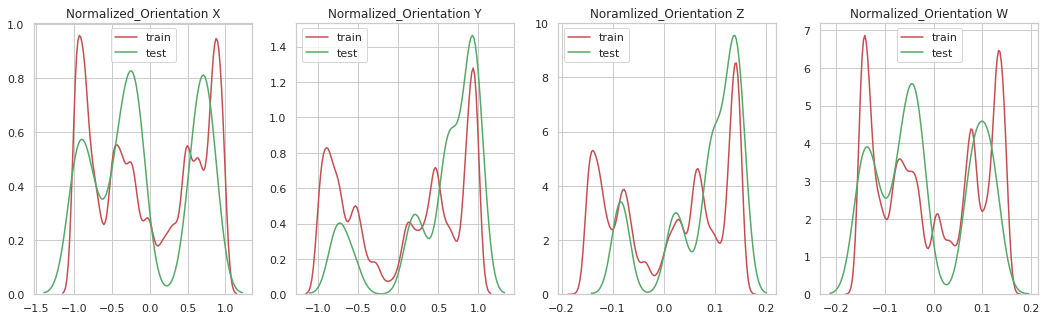

In [954]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('Normalized_Orientation X')
sns.kdeplot(X_train['norm_orientation_X'], ax=ax1, label="train", color = 'r')
sns.kdeplot(X_test['norm_orientation_X'], ax=ax1, label="test",color = 'g')

ax2.set_title('Normalized_Orientation Y')
sns.kdeplot(X_train['norm_orientation_Y'], ax=ax2, label="train",color = 'r')
sns.kdeplot(X_test['norm_orientation_Y'], ax=ax2, label="test",color = 'g')

ax3.set_title('Noramlized_Orientation Z')
sns.kdeplot(X_train['norm_orientation_Z'], ax=ax3, label="train",color = 'r')
sns.kdeplot(X_test['norm_orientation_Z'], ax=ax3, label="test",color = 'g')

ax4.set_title('Normalized_Orientation W')
sns.kdeplot(X_train['norm_orientation_W'], ax=ax4, label="train",color = 'r')
sns.kdeplot(X_test['norm_orientation_W'], ax=ax4, label="test",color = 'g')

plt.show()

### Feature Engineering Part1:<br>
#### Adding sum(orientaion), sum(angular_vel), sum(linear_acc)

In [0]:
# modification from the @Nanashi 

def feat_eng(data):
    
    df = pd.DataFrame()
    data['sum_ang_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['sum_linear_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2 + data['orientation_W'])**0.5
    data['totl_normalized_xyz'] = (data['norm_orientation_X']**2 + data['norm_orientation_Y']**2 + data['norm_orientation_Z']**2 + data['norm_orientation_W'])**0.5
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [956]:
%%time
X_train_fe = feat_eng(X_train)

CPU times: user 46.4 s, sys: 238 ms, total: 46.6 s
Wall time: 46.8 s


In [957]:
X_train_fe.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,orientation_W_abs_max,orientation_W_abs_min,orientation_W_abs_avg,...,sum_ang_vel_mean,sum_ang_vel_median,sum_ang_vel_max,sum_ang_vel_min,sum_ang_vel_std,sum_ang_vel_range,sum_ang_vel_maxtoMin,sum_ang_vel_abs_max,sum_ang_vel_abs_min,sum_ang_vel_abs_avg,sum_linear_acc_mean,sum_linear_acc_median,sum_linear_acc_max,sum_linear_acc_min,sum_linear_acc_std,sum_linear_acc_range,sum_linear_acc_maxtoMin,sum_linear_acc_abs_max,sum_linear_acc_abs_min,sum_linear_acc_abs_avg,totl_xyz_mean,totl_xyz_median,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_range,totl_xyz_maxtoMin,totl_xyz_abs_max,totl_xyz_abs_min,totl_xyz_abs_avg,totl_normalized_xyz_mean,totl_normalized_xyz_median,totl_normalized_xyz_max,totl_normalized_xyz_min,totl_normalized_xyz_std,totl_normalized_xyz_range,totl_normalized_xyz_maxtoMin,totl_normalized_xyz_abs_max,totl_normalized_xyz_abs_min,totl_normalized_xyz_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.75953,0.75822,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000471,0.00150,0.997636,0.63456,0.63306,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000432,0.001530,0.985585,0.106140,0.104610,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,0.000389,0.001460,0.986362,0.107050,0.105590,0.106320,...,0.057668,0.052661,0.162384,0.010603,0.028263,0.151781,15.314654,0.162384,0.010603,0.086494,9.939676,10.077860,12.575577,7.117152,0.989642,5.458424,1.766939,12.575577,7.117152,9.846364,0.939252,0.939197,0.939823,0.938877,0.000251,0.000947,1.001008,0.939823,0.938877,0.939350,0.939252,0.939197,0.939820,0.938877,0.000251,0.000943,1.001004,0.939820,0.938877,0.939348
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.95896,0.95837,0.958665,0.241867,0.241890,0.24270,0.24074,0.000499,0.00196,1.008142,0.24270,0.24074,0.241720,0.031650,0.031688,0.032341,0.030504,0.000508,0.001837,1.060222,0.032341,0.030504,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,0.000521,0.002220,0.985009,0.148090,0.145870,0.146980,...,0.111790,0.101244,0.287947,0.020167,0.052645,0.267779,14.277849,0.287947,0.020167,0.154057,10.082444,10.069950,16.986332,5.867993,1.826016,11.118339,2.894743,16.986332,5.867993,11.427163,0.911895,0.911869,0.912608,0.911032,0.000369,0.001576,1.001730,0.912608,0.911032,0.911820,0.911895,0.911870,0.912607,0.911032,0.000370,0.001575,1.001729,0.912607,0.911032,0.911820
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.51434,0.50944,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000785,0.00289,0.996591,0.84779,0.84490,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000541,0.001780,0.986339,0.130300,0.128520,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,0.000278,0.001157,0.983826,0.071535,0.070378,0.070957,...,0.071090,0.067325,0.170919,0.009871,0.033906,0.161048,17.314963,0.170919,0.009871,0.090395,10.035741,10.082289,12.725500,6.794325,0.944637,5.931175,1.872960,12.725500,6.794325,9.759913,0.961179,0.961148,0.961592,0.960911,0.000165,0.000681,1.000709,0.961592,0.960911,0.961251,0.961179,0.961145,0.961597,0.960910,0.000165,0.000687,1.000715,0.961597,0.960910,0.961253
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.93968,0.

In [958]:
%%time
X_test_fe = feat_eng(X_test)

CPU times: user 541 ms, sys: 3.91 ms, total: 545 ms
Wall time: 557 ms


In [959]:
X_test_fe.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,orientation_W_abs_max,orientation_W_abs_min,orientation_W_abs_avg,...,sum_ang_vel_mean,sum_ang_vel_median,sum_ang_vel_max,sum_ang_vel_min,sum_ang_vel_std,sum_ang_vel_range,sum_ang_vel_maxtoMin,sum_ang_vel_abs_max,sum_ang_vel_abs_min,sum_ang_vel_abs_avg,sum_linear_acc_mean,sum_linear_acc_median,sum_linear_acc_max,sum_linear_acc_min,sum_linear_acc_std,sum_linear_acc_range,sum_linear_acc_maxtoMin,sum_linear_acc_abs_max,sum_linear_acc_abs_min,sum_linear_acc_abs_avg,totl_xyz_mean,totl_xyz_median,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_range,totl_xyz_maxtoMin,totl_xyz_abs_max,totl_xyz_abs_min,totl_xyz_abs_avg,totl_normalized_xyz_mean,totl_normalized_xyz_median,totl_normalized_xyz_max,totl_normalized_xyz_min,totl_normalized_xyz_std,totl_normalized_xyz_range,totl_normalized_xyz_maxtoMin,totl_normalized_xyz_abs_max,totl_normalized_xyz_abs_min,totl_normalized_xyz_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3790,0.710416,0.710435,0.71142,0.70935,0.000525,0.00207,1.002918,0.71142,0.70935,0.710385,0.687769,0.687775,0.68865,0.68675,0.000523,0.00190,1.002767,0.68865,0.68675,0.687700,0.107808,0.107775,0.109680,0.105830,0.000706,0.003850,1.036379,0.109680,0.105830,0.107755,0.103248,0.103300,0.104500,0.101390,0.000550,0.003110,1.030674,0.104500,0.101390,0.102945,...,0.363738,0.295253,0.975822,0.053585,0.236463,0.922237,18.210641,0.975822,0.053585,0.514704,13.296905,11.402018,33.028862,2.890788,6.836518,30.138074,11.425557,33.028862,2.890788,17.959825,1.045270,1.045287,1.045741,1.044562,0.000209,0.001178,1.001128,1.045741,1.044562,1.045152,1.045269,1.045289,1.045744,1.044562,0.000209,0.001182,1.001131,1.045744,1.044562,1.045153
3791,0.804211,0.803990,0.80611,0.80275,0.000996,0.00336,1.004186,0.80611,0.80275,0.804430,-0.574625,-0.574055,-0.57208,-0.57763,0.001544,0.00555,0.990392,0.57763,0.57208,0.574855,-0.083750,-0.083600,-0.080153,-0.089394,0.002116,0.009241,0.896626,0.089394,0.080153,0.084774,0.126576,0.126720,0.132450,0.119800,0.002770,0.012650,1.105593,0.132450,0.119800,0.126125,...,0.432448,0.232181,1.773270,0.034159,0.417845,1.739111,51.912716,1.773270,0.034159,0.903714,22.903142,12.192883,139.704969,3.430561,22.433611,136.274408,40.723655,139.704969,3.430561,71.567765,1.053825,1.053879,1.055896,1.051402,0.000982,0.004494,1.004274,1.055896,1.051402,1.053649,1.053825,1.053880,1.055891,1.051403,0.000982,0.004488,1.004269,1.055891,1.051403,1.053647
3792,0.640428,0.640285,0.64262,0.63847,0.001154,0.00415,1.006500,0.64262,0.63847,0.640545,-0.759004,-0.758990,-0.75698,-0.76053,0.000958,0.00355,0.995332,0.76053,0.75698,0.758755,-0.083907,-0.084093,-0.082573,-0.085034,0.000660,0.002461,0.971059,0.085034,0.082573,0.083804,0.081981,0.081959,0.083147,0.081091,0.000532,0.002056,1.025354,0.083147,0.081091,0.082119,...,0.070508,0.065532,0.176410,0.009460,0.031618,0.166951,18.648937,0.176410,0.009460,0.092935,9.906969,9.988305,12.120578,8.062241,0.729378,4.058337,1.503376,12.120578,8.062241,10.091409,1.036947,1.036939,1.037416,1.036588,0.000214,0.000828,1.000799,1.037416,1.036588,1.037002,1.036947,1.036938,1.037417,1.036588,0.000214,0.000829,1.000799,1.037417,1.036588,1.037003
3793,-0.977197,-0.977295,-0.97569,-0.97818,0.000703,0.00249,0.997454,0.97818,0.9756

In [960]:
len(X_test_fe.columns)

200

### Feature Engineering Part2:

**According to the data , we add some additional features for Orientation data** 

In [961]:
ordat= X_train.filter(regex=("ori.*" or "norm_ori.*"))
list(ordat.columns)


['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'norm_orientation_X',
 'norm_orientation_Y',
 'norm_orientation_Z',
 'norm_orientation_W']

In order to use more information, we add some more data.

In [0]:
def fe_advanced_stats(data,data_fe):
    orientation_col = list(data.filter(regex=("ori.*" or "norm_ori.*")))
    for col in orientation_col:
        data_fe[col + '_skew'] = data.groupby(['series_id'])[col].skew()
        data_fe[col + '_q25'] = data.groupby(['series_id'])[col].quantile(0.25)
        data_fe[col + '_q75'] = data.groupby(['series_id'])[col].quantile(0.75)
        data_fe[col + '_q95'] = data.groupby(['series_id'])[col].quantile(0.95)
    return data_fe

In [963]:
X_train_fe2 = fe_advanced_stats(X_train,X_train_fe)
X_train_fe2
len(X_train_fe2.columns)

232

In [964]:
%%time
X_test_fe2 = fe_advanced_stats(X_test,X_test_fe)
X_test_fe2
len(X_test_fe2.columns)

CPU times: user 105 ms, sys: 999 µs, total: 106 ms
Wall time: 107 ms


**We are done with some simple feature engineering. let's fit the Random forest model and do further analysis.**

# 6) Model Fitting

**Random Forest**<br>

#### 1) Model

In [0]:
le = preprocessing.LabelEncoder()

In [966]:
train_numeric_labels = le.fit_transform(y_train['surface'])
train_numeric_labels

array([2, 1, 1, ..., 1, 5, 8])

In [967]:
len(train_numeric_labels)

3790

In [0]:
rf = RandomForestClassifier(n_estimators = 5, random_state = 50, n_jobs= -1) # Creating Gaussian Classifier

In [969]:
%%time
rf.fit(X_train_fe2,train_numeric_labels)

CPU times: user 351 ms, sys: 6.98 ms, total: 358 ms
Wall time: 231 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
                       oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

#### 2) Prediction

In [970]:
%%time
predicted_labels = rf.predict(X_test_fe2)
predicted_labels

CPU times: user 8.81 ms, sys: 2.01 ms, total: 10.8 ms
Wall time: 110 ms


#### 3) Change Test Labels to categorical labels

In [971]:
test_label = le.inverse_transform(predicted_labels)
test_label

array(['hard_tiles_large_space', 'concrete', 'soft_pvc', 'tiled',
       'hard_tiles_large_space', 'concrete', 'wood', 'concrete',
       'concrete', 'tiled', 'concrete', 'hard_tiles_large_space', 'tiled',
       'wood', 'tiled', 'tiled', 'wood', 'tiled', 'tiled', 'soft_pvc'],
      dtype=object)

In [972]:
y_test_arr = np.array(y_test['surface'])
y_test_arr

array(['hard_tiles_large_space', 'concrete', 'soft_pvc', 'tiled',
       'hard_tiles_large_space', 'concrete', 'wood', 'fine_concrete',
       'concrete', 'tiled', 'fine_concrete', 'hard_tiles_large_space',
       'tiled', 'wood', 'tiled', 'tiled', 'wood', 'fine_concrete',
       'tiled', 'soft_pvc'], dtype=object)

### What are the confusing surfaces for our model? 


In [973]:
def confused(test,result):
  confused = []
  for i in range(len(test)):
    if test[i] != result[i]:
      diff = [test[i],result[i]]
      confused.append(diff)
  return(confused)

confused(y_test_arr,test_label)


[['fine_concrete', 'concrete'],
 ['fine_concrete', 'concrete'],
 ['fine_concrete', 'tiled']]

**We got our label as categorical variables!**<br>
We need to compare __test_label vs y_test__ to get accuracy of the model.<br>

#### 5) Evaluate error rate 

In [0]:
def evaluate(y_test, test_label):
    # use for-loop to determine diffence in categorical variable
    
    error = 0
    for i in range(len(test_label)):
        if test_label[i] != y_test[i]:
            error = error+1
            
    accuracy = (1- (error/len(test_label)))*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [975]:
evaluate(y_test_arr,test_label)

Model Performance
Accuracy = 85.00%.


85.0

**With 130 number of columns, we get 80 % of accuracy.**

# 7) Feature Importance 

In [0]:
importances = list(rf.feature_importances_)

In [977]:
sel = SelectFromModel(rf)
sel.fit(X_train_fe2, train_numeric_labels)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=5, n_jobs=-1,
                                                 oob_score=False,
   

In [978]:
sel.get_support()


array([False,  True, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
        True, False,  True, False,  True, False,  True, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False, False,  True, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
        True, False,  True, False, False,  True, False,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
        True, False,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False,  True,

**Observation:** <br>
__True:__ features that are importace is __greater than the mean importance.__ <br>
__False: less than the mean importance.__

In [979]:
selected_feat= X_train_fe.columns[(sel.get_support())]
len(selected_feat)
#len(selected_feat)

81

**We have 56 features that are important than the mean importance**

In [980]:
print(selected_feat)


Index(['orientation_X_median', 'orientation_X_min', 'orientation_X_range',
       'orientation_X_abs_max', 'orientation_Y_abs_max', 'orientation_Z_mean',
       'orientation_Z_median', 'orientation_Z_max', 'orientation_Z_min',
       'orientation_Z_maxtoMin', 'orientation_Z_abs_max',
       'orientation_Z_abs_avg', 'orientation_W_median', 'orientation_W_min',
       'orientation_W_maxtoMin', 'orientation_W_abs_min',
       'angular_velocity_X_std', 'angular_velocity_X_abs_max',
       'angular_velocity_Y_mean', 'angular_velocity_Y_range',
       'angular_velocity_Z_mean', 'angular_velocity_Z_min',
       'angular_velocity_Z_abs_max', 'linear_acceleration_X_max',
       'linear_acceleration_X_std', 'linear_acceleration_X_abs_max',
       'linear_acceleration_X_abs_avg', 'linear_acceleration_Y_max',
       'linear_acceleration_Y_min', 'linear_acceleration_Y_std',
       'linear_acceleration_Z_mean', 'linear_acceleration_Z_max',
       'linear_acceleration_Z_min', 'linear_acceleration_Z_r

### Delete unimportant features 

In [0]:
X_train_fe_columns = list(X_train_fe.columns)
removing_fe = list(set(X_train_fe_columns) - set(selected_feat))

In [982]:
len(removing_fe)

151

In [983]:
print("we removed ", len(removing_fe), "features")

we removed  151 features


In [0]:
X_train_fe2_removed = X_train_fe2.drop(removing_fe, axis=1)

In [985]:
X_train_fe2_removed.columns

Index(['orientation_X_median', 'orientation_X_min', 'orientation_X_range',
       'orientation_X_abs_max', 'orientation_Y_abs_max', 'orientation_Z_mean',
       'orientation_Z_median', 'orientation_Z_max', 'orientation_Z_min',
       'orientation_Z_maxtoMin', 'orientation_Z_abs_max',
       'orientation_Z_abs_avg', 'orientation_W_median', 'orientation_W_min',
       'orientation_W_maxtoMin', 'orientation_W_abs_min',
       'angular_velocity_X_std', 'angular_velocity_X_abs_max',
       'angular_velocity_Y_mean', 'angular_velocity_Y_range',
       'angular_velocity_Z_mean', 'angular_velocity_Z_min',
       'angular_velocity_Z_abs_max', 'linear_acceleration_X_max',
       'linear_acceleration_X_std', 'linear_acceleration_X_abs_max',
       'linear_acceleration_X_abs_avg', 'linear_acceleration_Y_max',
       'linear_acceleration_Y_min', 'linear_acceleration_Y_std',
       'linear_acceleration_Z_mean', 'linear_acceleration_Z_max',
       'linear_acceleration_Z_min', 'linear_acceleration_Z_r

In [986]:
len(X_train_fe2_removed.columns)

81

In [987]:
print("We are using", len(X_train_fe2_removed.columns), "features")

We are using 81 features


### Test accuracy after removing unimportant features 

In [988]:
%%time
rf.fit(X_train_fe2_removed,train_numeric_labels)

CPU times: user 204 ms, sys: 3.94 ms, total: 208 ms
Wall time: 217 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
                       oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [0]:
# remove the same columns for X_test_fe 
X_test_fe2_removed = X_test_fe2.drop(removing_fe, axis=1)

Make sure we changed for the test data as well.

In [990]:
%%time
predicted_labels_fe2_removed = rf.predict(X_test_fe2_removed)
predicted_labels_fe2_removed

CPU times: user 5.88 ms, sys: 1.95 ms, total: 7.84 ms
Wall time: 113 ms


In [991]:
test_label_fe2_removed = le.inverse_transform(predicted_labels_fe2_removed)
test_label_fe2_removed

array(['hard_tiles_large_space', 'concrete', 'soft_pvc', 'tiled',
       'hard_tiles_large_space', 'concrete', 'wood', 'fine_concrete',
       'concrete', 'tiled', 'soft_pvc', 'hard_tiles_large_space', 'tiled',
       'wood', 'tiled', 'tiled', 'wood', 'concrete', 'fine_concrete',
       'soft_pvc'], dtype=object)

In [992]:
evaluate(y_test_arr,test_label_fe2_removed)

Model Performance
Accuracy = 85.00%.


85.0

In [993]:
confused(y_test_arr, test_label_fe2_removed)

[['fine_concrete', 'soft_pvc'],
 ['fine_concrete', 'concrete'],
 ['tiled', 'fine_concrete']]

# 8)  Results

Model Used: __Random Forest__<br>
- n_estimator = 5<br>
- n_jobs = -1<br>
- random state = 50 (can be any number)

Number of Used Features: __81__<br>
Accuracy: __85.00 %__<br>